In [248]:
# !python script.py

In [249]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
# from torchvision import models
from torchsummary import summary
import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix


from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
import validators

import argparse
import re
from collections import Counter

import logging


In [250]:

print("number_of_cpus: ", torch.get_num_threads())
torch.set_num_threads(16)
print("confined to number_of_cpus: ", torch.get_num_threads())

number_of_cpus:  16
confined to number_of_cpus:  16


In [251]:
## using argparse to set parameters
parser = argparse.ArgumentParser(description='Train model on UCB Image Dataset')
parser.add_argument('--source_dataset_dir', type=str, default='/projectnb/cs640grp/materials/UBC-OCEAN_CS640', help='path to dataset')
parser.add_argument('--local_dataset_dir', type=str, default='../../../dataset', help='path to local dataset')
parser.add_argument('--model_dir', type=str, default='./model', help='path to tained model')
parser.add_argument('--experiment_name', type=str, default='exp_1', help='experiment name')

parser.add_argument('--train_image_folder', type=str, default='img_size_512x512', help='training image folder name')
parser.add_argument('--eval_image_folder', type=str, default='test_img_size_512x512', help='evaluate image folder name')
# parser.add_argument('--train_image_folder', type=str, default='train_images_compressed_80', help='training image folder name')
parser.add_argument('--image_input_size', type=str, default='(512, 512)', help='input image size')
parser.add_argument('--batch_size', type=int, default=8, help='batch size')
parser.add_argument('--num_epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
# parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=0.0001, help='weight decay')
parser.add_argument('--eval_patience', type=int, default=20, help='patience for early stopping')

_StoreAction(option_strings=['--eval_patience'], dest='eval_patience', nargs=None, const=None, default=20, type=<class 'int'>, choices=None, required=False, help='patience for early stopping', metavar=None)

In [252]:
setting = None
try:
    __IPYTHON__
    _in_ipython_session = True
    settings = parser.parse_args("")
except NameError:
    _in_ipython_session = False
    settings = parser.parse_args()

print("settings:", vars(settings))
# # save settings in to a log file
# with open(Path(settings.model_dir, settings.experiment_name, 'settings.txt'), 'w') as f:
#     print(vars(settings), file=f)

settings: {'source_dataset_dir': '/projectnb/cs640grp/materials/UBC-OCEAN_CS640', 'local_dataset_dir': '../../../dataset', 'model_dir': './model', 'experiment_name': 'exp_1', 'train_image_folder': 'img_size_512x512', 'eval_image_folder': 'test_img_size_512x512', 'image_input_size': '(512, 512)', 'batch_size': 8, 'num_epochs': 10, 'lr': 0.001, 'weight_decay': 0.0001, 'eval_patience': 20}


In [253]:
image_input_size = eval(settings.image_input_size)
assert isinstance(image_input_size, tuple) and len(image_input_size) == 2, "image_input_size must be a tuple of length 2"

# # vars(settings)
# # print(image_input_size)

In [254]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000
# IMAGE_INPUT_SIZE = (2048, 2048)

IMAGE_INPUT_SIZE = image_input_size

In [255]:
def create_dir_if_not_exist(dir):
    # if not os.path.exists(dir):
    #     os.makedirs(dir)
    if not Path(dir).exists():
        Path(dir).mkdir(parents=True, exist_ok=True)

In [256]:
SOURCE_DATASET_DIR = settings.source_dataset_dir
# DATASET_PATH = "dataset"
# TRAIN_IMAGE_FOLDER = "train_images_compressed_80"
# TEST_IMAGE_FOLDER = "test_images_compressed_80"
# TRAIN_IMAGE_FOLDER = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}"
TRAIN_IMAGE_FOLDER = settings.train_image_folder
EVAL_IMAGE_FOLDER = settings.eval_image_folder


# LOCAL_DATASET_DIR = "./dataset"
# MODEL_DIR = "./model/"
# EXPERIMENT_NAME = "exp_1"

LOCAL_DATASET_DIR = settings.local_dataset_dir
MODEL_DIR = settings.model_dir
EXPERIMENT_NAME = settings.experiment_name

sub_folder_name = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}_lr_{settings.lr}__batch_size_{settings.batch_size}__num_epochs_{settings.num_epochs}__weight_decay_{settings.weight_decay}__eval_patience_{settings.eval_patience}"
sub_folder_name = re.sub(r"\.", "p", sub_folder_name)
MODEL_SAVE_DIR = Path(MODEL_DIR, EXPERIMENT_NAME, sub_folder_name)
RESULT_DIR = Path("./result", EXPERIMENT_NAME, sub_folder_name)
print("RESULT_DIR:", RESULT_DIR)

LOG_DIR = Path("./log", EXPERIMENT_NAME)
print("LOG_DIR:", LOG_DIR)
create_dir_if_not_exist(LOG_DIR)


RESULT_DIR: result\exp_1\img_size_512x512_lr_0p001__batch_size_8__num_epochs_10__weight_decay_0p0001__eval_patience_20
LOG_DIR: log\exp_1


In [257]:
# # logging.basicConfig(level=logging.DEBUG)



# logging.basicConfig(level=logging.INFO, filename='log.txt', filemode='w',
logging.basicConfig(level=logging.DEBUG, filename=LOG_DIR/'log.txt', filemode='w',
	format='[%(asctime)s %(levelname)-8s] %(message)s',
	datefmt='%Y%m%d %H:%M:%S',
	)

# if __name__ == "__main__":
# 	logging.debug('debug')
# 	logging.info('info')
# 	logging.warning('warning')
# 	logging.error('error')
# 	logging.critical('critical')
# 	time.sleep(5)


In [258]:
# lr = 0.001
# # momentum = 0.9
# weight_decay = 0.0001
# num_epochs = 20
# batch_size = 32

eval_patience = settings.eval_patience
lr = settings.lr
# momentum = settings.momentum
weight_decay = settings.weight_decay
num_epochs = settings.num_epochs
batch_size = settings.batch_size

In [259]:
create_dir_if_not_exist(LOCAL_DATASET_DIR)

In [260]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [261]:
#pandas load data from csv
train_csv = None
test_csv = None
all_labels = None

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'train.csv'):
    train_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'train.csv').to_numpy()
else:
    train_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'train.csv').to_numpy()

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'test.csv'):
    test_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'test.csv').to_numpy()
else:
    test_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'test.csv').to_numpy()

# load npy
if os.path.exists(Path(LOCAL_DATASET_DIR) / 'all_labels.npy'):
    all_labels = np.load(Path(LOCAL_DATASET_DIR) / 'all_labels.npy')
else:
    all_labels = np.load(Path(SOURCE_DATASET_DIR) / 'all_labels.npy')




In [262]:
dict_id_to_label = {i: label for i, label in enumerate(all_labels)}
dict_label_to_id = {label: i for i, label in enumerate(all_labels)}


print("dict_id_to_label:", sorted(dict_id_to_label.items()))

dict_id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]


In [263]:
def tran_csv_to_img_path_and_label(x_csv, data_path, image_folder, dict_label_to_id):
    x_data = []
    for i in range(len(x_csv)):
        #get img path
        img_name = str(x_csv[i][0]) + ".jpg"
        img_path = Path(data_path)  / image_folder / img_name
        # check image is exist
        if not img_path.exists():
            print(f"image {img_path} does not exist")
            continue

        x_data.append([img_path, dict_label_to_id[x_csv[i][1]]])
    return x_data

In [264]:
train_image_path_and_label = tran_csv_to_img_path_and_label(train_csv, LOCAL_DATASET_DIR, TRAIN_IMAGE_FOLDER, dict_label_to_id)
test_image_path_and_label = tran_csv_to_img_path_and_label(test_csv, LOCAL_DATASET_DIR, EVAL_IMAGE_FOLDER, dict_label_to_id)

# # Random split
# # train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42)
# train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42, 
#                                         stratify=[x[1] for x in train_image_path_and_label])
train_set = train_image_path_and_label
valid_set = test_image_path_and_label

if EXPERIMENT_NAME == "efficientnet_b0__train_on_all_data":
    train_set = train_image_path_and_label + test_image_path_and_label

print("train set size:", len(train_set))    
print("valid set size:", len(valid_set))
# print("test set size:", len(test_set))

path_list, labels = zip(*train_set)
print("train set category distribution: \n\t", Counter(labels))

path_list, labels = zip(*valid_set)
print("train set category distribution: \n\t", Counter(labels))

train set size: 430
valid set size: 108
train set category distribution: 
	 Counter({0: 177, 1: 99, 3: 79, 4: 38, 2: 37})
train set category distribution: 
	 Counter({0: 45, 1: 25, 3: 20, 2: 9, 4: 9})


In [265]:
def show_img_by_path(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print(img.size, type(img))
    img = transforms.Resize(IMAGE_INPUT_SIZE)(img)
    print(img.size, type(img))
    img = transforms.ToTensor()(img)
    print(img.shape)
    # print(img)
    
# show_img_by_path(train_set[0][0])

In [266]:
from torchvision.io import read_image

class UBCDataset(Dataset):
    def __init__(self, img_path_and_label, transform=None, target_transform=None, random_add_single_value=False):
        self.data = img_path_and_label
        self.transform = transform
        self.target_transform = target_transform
        self.random_add_single_value = random_add_single_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = read_image(img_path)
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        # print(np.max(image), np.min(image))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(torch.max(image), torch.min(image))
        
        if self.random_add_single_value:
            image += torch.randn(1) * 0.01
        return image, label


In [267]:
# put data into dataloader
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(180),
    transforms.RandomAffine(180, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# v2.Compose([v2.Resize(256, antialias = True),
#                               v2.CenterCrop(224),
#                               v2.ToImage(),
#                               v2.ToDtype(torch.float32, scale = True),
#                               v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])


test_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_dataset = UBCDataset(train_set, transform=train_transform, random_add_single_value=True)
valid_dataset = UBCDataset(valid_set, transform=test_transform)
# test_dataset = UBCDataset(test_set, transform=test_transform)



C:\Users\benve\AppData\Local\Temp\ipykernel_23812\1872759898.py:7: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomAffine(180, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=PIL.Image.BILINEAR),


In [268]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [269]:
#show image grid
def show_image_grid(dataloader, num_of_images=16):
    imgs, labels = next(iter(dataloader))
    image_grid = torchvision.utils.make_grid(imgs[:num_of_images], nrow=8)
    plt.imshow(image_grid.permute(1, 2, 0).numpy())
    # plt.show()
    print("labels:", labels[:num_of_images], [dict_id_to_label[label.item()] for label in labels[:num_of_images]])

# show_image_grid(train_dataloader)

In [270]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_v2_l', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)

# print(dir(efficientnet.modules))
# print(efficientnet.classifier.fc.in_features)

In [271]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

if EXPERIMENT_NAME == "efficientnet_b0":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_b4":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_widese_b0":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_widese_b4":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
# elif EXPERIMENT_NAME == "efficientnet_v2_l":
#     efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_v2_l', pretrained=True)

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)
# vars(efficientnet)


Using cache found in C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [272]:
model_raw = efficientnet
classifier_in_feature_size = model_raw.classifier.fc.in_features
classifier_head = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=classifier_in_feature_size, out_features=256, bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=256, out_features=5, bias=True),
)
model_raw.classifier = classifier_head
model_raw = model_raw.to(device)


feature_extractor_params = []
for name, params in model_raw.named_parameters():
    if(name[:10] == "classifier"):
        continue
    feature_extractor_params.append(params)

classifier_head_params = []
for name, params in classifier_head.named_parameters():
    classifier_head_params.append(params)


In [273]:
# print("feature_extractor_params:", len(feature_extractor_params))
# print(classifier_head_params)

In [274]:
summary(model_raw, (3, ) + IMAGE_INPUT_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              SiLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              SiLU-6         [-1, 32, 256, 256]               0
            Linear-7                    [-1, 8]             264
              SiLU-8                    [-1, 8]               0
            Linear-9                   [-1, 32]             288
          Sigmoid-10                   [-1, 32]               0
SequentialSqueezeAndExcitation-11         [-1, 32, 256, 256]               0
           Conv2d-12         [-1, 16, 256, 256]             512
      BatchNorm2d-13         [-1, 16, 256, 256]              32
      MBConvBlock-14      

In [275]:

criteria = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_raw.classifier.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.Adam([{"params":feature_extractor_params, "lr":1e-7}, {"params":classifier_head_params, "lr":lr}], 
                       lr=lr, weight_decay=weight_decay)



In [276]:


def get_category_accuracy(y_gt: np.array, y_pred: np.array, n_category):
    # category_accuracy = np.zeros(n_category)

    assert(len(y_gt) == len(y_pred))
    assert(len(y_gt.shape) == 1 and len(y_pred.shape) == 1)

    cat_mask_2d = (y_gt == np.arange(n_category).reshape(-1, 1))
    category_accuracy = ((y_gt == y_pred) * cat_mask_2d).sum(axis=1) / cat_mask_2d.sum(axis=1)

    return category_accuracy

# a = np.random.randint(0, 5, 10)
# b = np.random.randint(0, 5, 10)
# print("a:", a)
# print("b:", b)

# # print("get_category_accuracy:", get_category_accuracy(y_gt=a, y_pred=b, n_category=5))
# category_accuracy = get_category_accuracy(y_gt=np.array(a), y_pred=np.array(b), n_category=5)
# print("category_accuracy:", category_accuracy)
# print(str(category_accuracy))
# print(type(category_accuracy[0]))
# confusion_matrix_result = confusion_matrix(y_true=a, y_pred=b, labels=[0, 1, 2, 3, 4])
# print("get_category_accuracy:" + str(category_accuracy))


In [277]:
def evaluation(model, valid_dataloader, criteria, device):
        model.eval()
        valid_loss = 0.0
        valid_corrects = 0

        y_gt = []
        y_pred = []

        for imgs, labels in tqdm(valid_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(imgs)
                _, preds = torch.max(outputs, -1)
                loss = criteria(outputs, labels)

            valid_loss += loss.item() * imgs.size(0)
            valid_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

            y_gt.extend(labels.data.cpu().numpy().reshape(-1))
            y_pred.extend(preds.cpu().numpy().reshape(-1))

        # print(y_gt)
        # print(y_pred)
        confusion_matrix_result = confusion_matrix(y_gt, y_pred)
        print("confusion_matrix_result:\n" + str(confusion_matrix_result))
        logging.info("confusion_matrix_result:\n" + str(confusion_matrix_result))

        category_accuracy = get_category_accuracy(y_gt=np.array(y_gt), y_pred=np.array(y_pred), n_category=5)
        print("get_category_accuracy:" + str(category_accuracy))
        logging.info("get_category_accuracy:" + str(category_accuracy))
        
        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = valid_corrects / len(valid_dataloader.dataset)

        valid_balanced_acc = balanced_accuracy_score(y_gt, y_pred)

        return valid_loss, valid_acc, valid_balanced_acc

In [278]:
def train(model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device):
    train_loss_list = []
    train_acc_list = []
    train_balanced_acc_list = []

    valid_loss_list = []
    valid_acc_list = []
    valid_balanced_acc_list = []

    best_valid_loss = float('inf')
    best_valid_acc = -0.0001
    best_valid_balanced_acc = -0.0001

    best_model_valid_loss = None
    best_model_valid_acc = None
    best_model_valid_balanced_acc = None

    start_time = time.time()

    counter_eval_not_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        logging.info(f'Epoch {epoch + 1}/{num_epochs}')
        logging.info('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0
        
        y_gt = []
        y_pred = []

        for imgs, labels in tqdm(train_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)


            outputs = model(imgs)
            _, preds = torch.max(outputs, -1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

            y_gt.extend(labels.data.cpu().numpy().reshape(-1))
            y_pred.extend(preds.cpu().numpy().reshape(-1))


        # print(y_gt)
        # print(y_pred)
        confusion_matrix_result = confusion_matrix(y_gt, y_pred)
        print("confusion_matrix_result:\n" + str(confusion_matrix_result))
        logging.info("confusion_matrix_result:\n" + str(confusion_matrix_result))

        category_accuracy = get_category_accuracy(y_gt=np.array(y_gt), y_pred=np.array(y_pred), n_category=5)
        print("get_category_accuracy:" + str(category_accuracy))
        logging.info("get_category_accuracy:" + str(category_accuracy))
        
        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_corrects / len(train_dataloader.dataset)
        train_balanced_acc = balanced_accuracy_score(y_gt, y_pred)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_balanced_acc_list.append(train_balanced_acc)

        print(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f} Balanced Acc: {train_balanced_acc:.4f}')
        logging.info(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f} Balanced Acc: {train_balanced_acc:.4f}')
        print("id_to_label:", sorted(dict_id_to_label.items()))
        logging.info("id_to_label:" + str(sorted(dict_id_to_label.items())))
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        logging.info(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

        valid_loss, valid_acc, valid_balanced_acc = evaluation(model, valid_dataloader, criteria, device)

        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        valid_balanced_acc_list.append(valid_balanced_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_valid_loss = copy.deepcopy(model)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_valid_acc = copy.deepcopy(model)
        # else:
        #     counter_eval_not_improve += 1

        if valid_balanced_acc > best_valid_balanced_acc:
            best_valid_balanced_acc = valid_balanced_acc
            best_model_valid_balanced_acc = copy.deepcopy(model)
        else:
            counter_eval_not_improve += 1


        print(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f} Balanced Acc: {valid_balanced_acc:.4f}')
        logging.info(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f} Balanced Acc: {valid_balanced_acc:.4f}')
        print("id_to_label:", sorted(dict_id_to_label.items()))
        logging.info("id_to_label:" + str(sorted(dict_id_to_label.items())))
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}\n\n')
        logging.info(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}\n\n')

        if counter_eval_not_improve >= eval_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            logging.info(f'Early stopping at epoch {epoch + 1}')
            break
        else:
            counter_eval_not_improve = 0

    return model, best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list, \
           best_valid_loss, best_valid_acc

In [279]:
def store_result(best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
                 train_loss_list, train_acc_list, train_balanced_acc_list, \
                 valid_loss_list, valid_acc_list, valid_balanced_acc_list):
    create_dir_if_not_exist(MODEL_SAVE_DIR)
    create_dir_if_not_exist(RESULT_DIR)

    torch.save(best_model_valid_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_acc.pth")
    torch.save(best_model_valid_loss.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_loss.pth")
    torch.save(best_model_valid_balanced_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_balanced_acc.pth")

    with open(Path(RESULT_DIR) / "train_loss_list.pkl", "wb") as f:
        pickle.dump(train_loss_list, f)
    with open(Path(RESULT_DIR) / "train_acc_list.pkl", "wb") as f:
        pickle.dump(train_acc_list, f)
    with open(Path(RESULT_DIR) / "train_balanced_acc_list.pkl", "wb") as f:
        pickle.dump(train_balanced_acc_list, f)

    with open(Path(RESULT_DIR) / "valid_loss_list.pkl", "wb") as f:
        pickle.dump(valid_loss_list, f)
    with open(Path(RESULT_DIR) / "valid_acc_list.pkl", "wb") as f:
        pickle.dump(valid_acc_list, f)
    with open(Path(RESULT_DIR) / "valid_balanced_acc_list.pkl", "wb") as f:
        pickle.dump(valid_balanced_acc_list, f)


In [280]:
def plot_train_eval_result(
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list):
    epochs = np.arange(1, len(train_loss_list) + 1)

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss_list, label='train')
    plt.plot(epochs, valid_loss_list, label='valid')
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(3, 1, 2)
    plt.plot(epochs, [x*100 for x in train_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_acc_list], label='valid')
    plt.title('Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, [x*100 for x in train_balanced_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_balanced_acc_list], label='valid')
    plt.title('Balanced Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy (%)')

    plt.tight_layout()

In [281]:
model_trained, best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
train_loss_list, train_acc_list, train_balanced_acc_list, \
valid_loss_list, valid_acc_list, valid_balanced_acc_list, \
best_valid_loss, best_valid_acc = \
train(model_raw, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device)

print("best_valid_loss:", np.min(valid_loss_list))
print("best_valid_acc:", np.max(valid_acc_list))
print("best_valid_balanced_acc:", np.max(valid_balanced_acc_list))


Epoch 1/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[163   9   0   3   2]
 [ 82  11   0   5   1]
 [ 29   4   0   3   1]
 [ 57   5   0  15   2]
 [ 26   6   0   5   1]]
get_category_accuracy:[0.92090395 0.11111111 0.         0.18987342 0.02631579]
Train loss: 1.4221 Acc: 0.4419 Balanced Acc: 0.2496
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:00:19


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[12  0  0 33  0]
 [ 5  0  0 20  0]
 [ 3  0  0  6  0]
 [ 0  0  0 20  0]
 [ 2  0  0  7  0]]
get_category_accuracy:[0.26666667 0.         0.         1.         0.        ]
Valid loss: 1.4924 Acc: 0.2963 Balanced Acc: 0.2533
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:00:21


Epoch 2/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[152  12   0  13   0]
 [ 65  23   0  11   0]
 [ 23   8   0   6   0]
 [ 31  14   0  34   0]
 [ 21  11   0   6   0]]
get_category_accuracy:[0.85875706 0.23232323 0.         0.43037975 0.        ]
Train loss: 1.2722 Acc: 0.4860 Balanced Acc: 0.3043
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:00:40


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[15  0  0 30  0]
 [ 4  0  0 21  0]
 [ 1  0  0  8  0]
 [ 0  0  0 20  0]
 [ 4  0  0  5  0]]
get_category_accuracy:[0.33333333 0.         0.         1.         0.        ]
Valid loss: 1.4924 Acc: 0.3241 Balanced Acc: 0.2667
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:00:42


Epoch 3/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[147  17   1  12   0]
 [ 47  36   1  15   0]
 [ 21   2   4  10   0]
 [ 27   4   0  48   0]
 [ 15   8   0  13   2]]
get_category_accuracy:[0.83050847 0.36363636 0.10810811 0.60759494 0.05263158]
Train loss: 1.1851 Acc: 0.5512 Balanced Acc: 0.3925
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:01


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[28  3  0 12  2]
 [ 8  6  0 11  0]
 [ 0  0  2  7  0]
 [ 3  0  0 16  1]
 [ 4  0  0  5  0]]
get_category_accuracy:[0.62222222 0.24       0.22222222 0.8        0.        ]
Valid loss: 1.3456 Acc: 0.4815 Balanced Acc: 0.3769
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:03


Epoch 4/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[143  21   0  11   2]
 [ 55  28   2  13   1]
 [ 15   4  10   6   2]
 [ 23   2   0  53   1]
 [ 19   2   1   9   7]]
get_category_accuracy:[0.8079096  0.28282828 0.27027027 0.67088608 0.18421053]
Train loss: 1.1343 Acc: 0.5605 Balanced Acc: 0.4432
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:23


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[23  6  0 14  2]
 [ 6  9  0  8  2]
 [ 0  0  3  6  0]
 [ 2  0  1 15  2]
 [ 3  0  1  5  0]]
get_category_accuracy:[0.51111111 0.36       0.33333333 0.75       0.        ]
Valid loss: 1.3062 Acc: 0.4630 Balanced Acc: 0.3909
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:25


Epoch 5/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[139  24   2  10   2]
 [ 46  43   2   7   1]
 [ 12   7  10   6   2]
 [ 20   8   0  48   3]
 [ 13   8   1   8   8]]
get_category_accuracy:[0.78531073 0.43434343 0.27027027 0.60759494 0.21052632]
Train loss: 1.0960 Acc: 0.5767 Balanced Acc: 0.4616
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:44


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[26  3  0 14  2]
 [ 6  6  0  9  4]
 [ 1  1  2  4  1]
 [ 1  0  1 16  2]
 [ 3  0  1  4  1]]
get_category_accuracy:[0.57777778 0.24       0.22222222 0.8        0.11111111]
Valid loss: 1.2597 Acc: 0.4722 Balanced Acc: 0.3902
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:01:46


Epoch 6/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[129  24   3  19   2]
 [ 42  40   2  12   3]
 [  9   7  13   5   3]
 [ 20   9   1  47   2]
 [ 17   4   1   9   7]]
get_category_accuracy:[0.72881356 0.4040404  0.35135135 0.59493671 0.18421053]
Train loss: 1.1113 Acc: 0.5488 Balanced Acc: 0.4527
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:05


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[24  6  0 14  1]
 [ 6 10  0  9  0]
 [ 1  1  3  4  0]
 [ 0  0  1 17  2]
 [ 3  0  1  4  1]]
get_category_accuracy:[0.53333333 0.4        0.33333333 0.85       0.11111111]
Valid loss: 1.2188 Acc: 0.5093 Balanced Acc: 0.4456
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:07


Epoch 7/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[144  15   3  13   2]
 [ 50  34   2  11   2]
 [ 10   8  14   3   2]
 [ 22   8   2  45   2]
 [ 11   6   2  14   5]]
get_category_accuracy:[0.81355932 0.34343434 0.37837838 0.56962025 0.13157895]
Train loss: 1.0698 Acc: 0.5628 Balanced Acc: 0.4473
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:26


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[24 10  0  8  3]
 [ 6 15  0  4  0]
 [ 1  1  3  4  0]
 [ 0  1  1 16  2]
 [ 3  0  1  4  1]]
get_category_accuracy:[0.53333333 0.6        0.33333333 0.8        0.11111111]
Valid loss: 1.1628 Acc: 0.5463 Balanced Acc: 0.4756
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:28


Epoch 8/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[143  18   1  14   1]
 [ 41  44   4   8   2]
 [ 11   7  12   5   2]
 [ 19   8   2  49   1]
 [ 12   6   2  10   8]]
get_category_accuracy:[0.8079096  0.44444444 0.32432432 0.62025316 0.21052632]
Train loss: 1.0390 Acc: 0.5953 Balanced Acc: 0.4815
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:48


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[29  7  0  5  4]
 [ 6 13  0  3  3]
 [ 0  2  4  2  1]
 [ 2  2  1 12  3]
 [ 4  0  0  1  4]]
get_category_accuracy:[0.64444444 0.52       0.44444444 0.6        0.44444444]
Valid loss: 1.0617 Acc: 0.5741 Balanced Acc: 0.5307
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:02:50


Epoch 9/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[132  29   3   9   4]
 [ 31  48   6  11   3]
 [  9   2  21   4   1]
 [ 14  12   1  48   4]
 [ 12   3   0   8  15]]
get_category_accuracy:[0.74576271 0.48484848 0.56756757 0.60759494 0.39473684]
Train loss: 1.0068 Acc: 0.6140 Balanced Acc: 0.5601
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:03:10


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[28  8  0  6  3]
 [ 5 15  0  3  2]
 [ 0  2  4  2  1]
 [ 1  1  1 14  3]
 [ 5  0  0  1  3]]
get_category_accuracy:[0.62222222 0.6        0.44444444 0.7        0.33333333]
Valid loss: 1.0326 Acc: 0.5926 Balanced Acc: 0.5400
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:03:12


Epoch 10/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[143  17   1  15   1]
 [ 44  43   2   9   1]
 [  7   8  17   3   2]
 [ 20   6   3  46   4]
 [ 12   1   1  11  13]]
get_category_accuracy:[0.8079096  0.43434343 0.45945946 0.58227848 0.34210526]
Train loss: 1.0075 Acc: 0.6093 Balanced Acc: 0.5252
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:03:31


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[23 19  0  1  2]
 [ 3 20  1  0  1]
 [ 0  3  6  0  0]
 [ 2  5  1  8  4]
 [ 3  3  0  0  3]]
get_category_accuracy:[0.51111111 0.8        0.66666667 0.4        0.33333333]
Valid loss: 1.0419 Acc: 0.5556 Balanced Acc: 0.5422
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:03:33


best_valid_loss: 1.032601930477001
best_valid_acc: 0.5925925925925926
best_valid_balanced_acc: 0.5422222222222223


In [282]:
# # train_loss_list = [data.cpu().item() for data in train_loss_list]
# train_acc_list = [data.cpu().item() for data in train_acc_list]
# # valid_loss_list = [data.cpu().item() for data in valid_loss_list]
# valid_acc_list = [data.cpu().item() for data in valid_acc_list]

In [283]:
store_result(best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
             train_loss_list, train_acc_list, train_balanced_acc_list, \
             valid_loss_list, valid_acc_list, valid_balanced_acc_list)

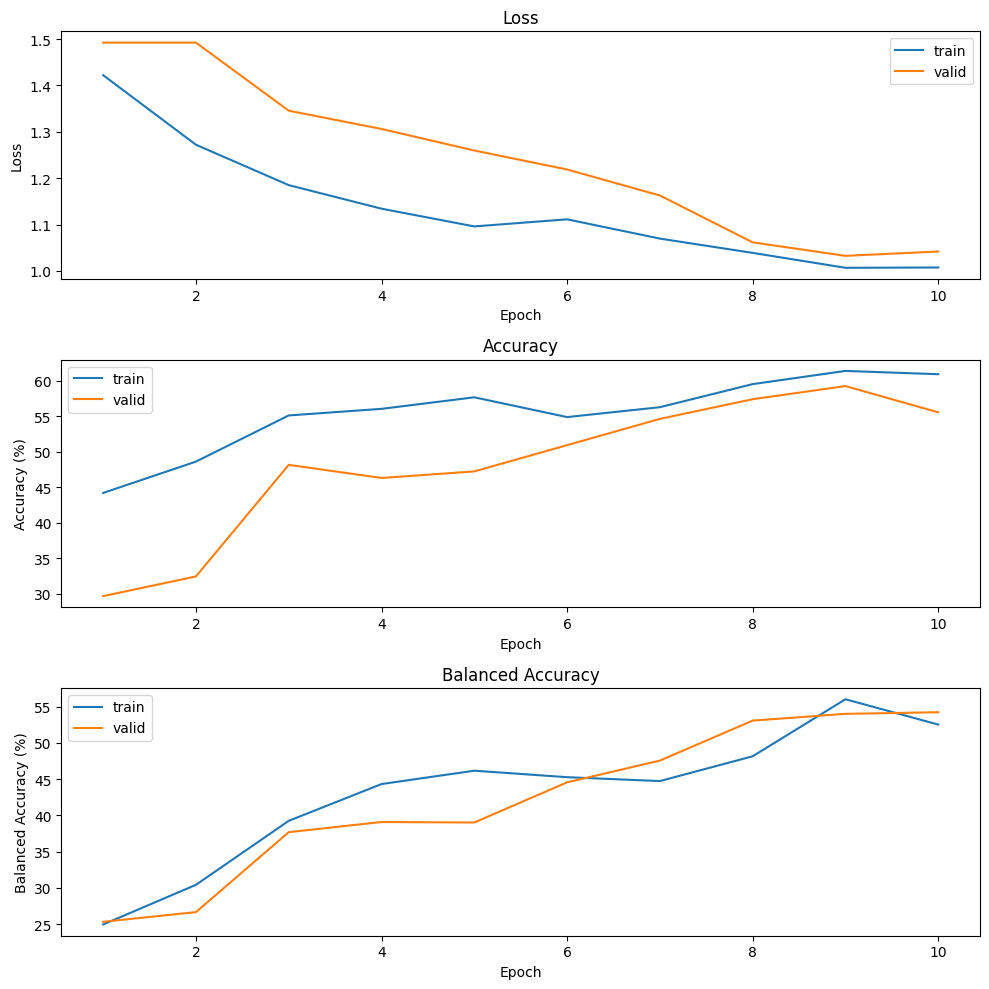

In [284]:
plot_train_eval_result(
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list)


In [285]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)


In [286]:
# # Download an example image
# import urllib
# url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)


In [287]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)


In [288]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms

# input_image = Image.open(filename)
# m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=m, std=s),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model = model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# print(torch.round(output[0]))